In [1]:
import numpy as np
import matplotlib.pyplot as plt
from class_def import *
from utils import *
import seaborn as sns

In [2]:
import re

class Naive_Spectrum_List:
    def __init__(self):
        self.__sorted = False
        self.spectrum_list = []
        self.metal_options = set()
        self.fcov_options = set()
        self.age_options = set()
        self.__metal_matcher = re.compile('Z=(\d+\.?\d*)')
        self.__fcov_matcher = re.compile('fcov_(\d+\.?\d*)')
        self.__age_matcher = re.compile('Age(\d+e\d)')

    def add_spectra(self, fname):
        try:
            metal_param = self.__metal_matcher.search(fname).group(1)
            fcov_param = self.__fcov_matcher.search(fname).group(1)
            age_param = self.__age_matcher.search(fname).group(1)
            self.metal_options.add( metal_param )
            self.fcov_options.add( fcov_param )
            self.age_options.add( age_param )
            spectrum_info = utils.readFile( fname )
            self.spectrum_list.append(
                Naive_Spectra.Naive_Spectra( metal_param, fcov_param, age_param, spectrum_info )
            )
        except:
            errmsg = "Error: Cannot parse the metallicity, covering factor and age information from the file name: "
            #correct_format = " Correct format of file name should include Z=<metallicity>_ , fcov_<covering_factor>, > for "
            print(errmsg , fname)

    def get_spectrum(self, param):
        '''
        The function takes a tuple of parameters, in the form of (metal, fcov, age) (in string),
        and return the required spectrum
        '''
        param_tuple = self._parse_param( param )
        return list(filter(
            lambda entry:
                entry.get_param() == param_tuple
            , self.spectrum_list
        ))[0]

    def sort_spectrum(self):
        # self.spectrum_arr = np.ones(len(self.fcov_options), len(self.metal_options), len(self.age_options), )
        self.__sorted = True

    def _parse_param(self, param):
        # return the tuple
        age_str = "{}e6".format( int(param[0] // 1e6) )
        return ( str(param[1]), str(param[2]), age_str )
def parse_model_filename(root, param):
    age_str = "{}e6".format( int(param[0] // 1e6) )
    fname = "Z={}_kroupa_IMF_fcov_{}_SFR_inst_Spectra_Age/Z={}_kroupa_IMF_fcov_{}_SFR_inst_Spectra_Age{}".format(
        param[1], param[2], param[1], param[2], age_str
    )
    return root + fname

from scipy.interpolate import interp1d
class SED_model:
    def __init__(self, spectra, interpolation=True):
        self._pack_spectra_to_model(spectra)
        if interpolation is True:
            self._init_interpolator()
        return
    def _init_interpolator(self):
        # log-linear interpolate only the age, flux and age in log space
        self.log_interpolator = interp1d( self.log10_age, self.model_log10base[:,:,0,0] )
        self.mass_die_interpolator = interp1d( self.log10_age, np.ones(len(self.log10_age)) )
        return
    def _pack_spectra_to_model(self, spectra):
        age_size = len(spectra.age_options)
        metal_size = len(spectra.metal_options)
        fcov_size = len(spectra.fcov_options)
        spectrum_wavelength = spectra.spectrum_list[0].get_spectra().shape[0]
        self.model_log10wavelength = np.zeros((spectrum_wavelength,age_size, metal_size, fcov_size))
        self.model_log10base = np.zeros((spectrum_wavelength,age_size, metal_size, fcov_size))# init the container
        self.log10_age = []
        for i, s in enumerate(spectra.spectrum_list):
            self.model_log10wavelength[:,i,0,0] = np.log10(s.get_spectra()[:,0])
            self.model_log10base[:,i,0,0] = np.log10( s.get_spectra()[:,1] )
            self.log10_age.append( np.log10( float(s.get_param()[2])) )
        self.log10_age = np.array(self.log10_age)
        return
    def evaluate(self, param):
        # the fraction of die off stars
        # the mass parameter we specified is (log10) ZAMS mass
        metal = int(param[3])
        fcov = int(param[4])
        ext = param[1]
        log10age = np.log10(param[2])
        log10mass = param[0] + np.log10(self.mass_die_interpolator(log10age))
        # the base sed is normalized to M_ZAMS = 10^6 solar mass 
        base_flux = self.log_interpolator(log10age) + (log10mass - 6) 
        return base_flux
    def evaluate_linear_flux(self, param):
        return np.power(10, self.evaluate(param))
    def get_wavelength(self):
        return np.power(10, self.model_log10wavelength[:,0,0,0])

In [3]:
modelNumAgeMap = np.array([1e6,2e6,3e6,4e6,5e6,6e6,7e6,8e6,9e6,1e7,1.1e7,1.2e7
                           ,1.3e7,1.4e7,1.5e7,2e7,3e7,4e7,5e7,6e7,7e7,8e7,9e7
                           ,1e8,2e8,3.02e8,4.01e8,5.03e8,6.04e8,7.06e8,8.02e8
                           ,9.11e8,1.007e9,2014e6,3036e6])
spectra = Naive_Spectrum_List()
for i in modelNumAgeMap:
    fname = parse_model_filename( "data/model/", [i, "0.02", "0"] )
    spectra.add_spectra( fname )
sed = SED_model(spectra)

In [4]:
# try to generate star according to sfr
def get_total_mass(t_grid, sfr, t_lim):
    # t_grid: the star formation rate at the grid point
    log10_t_sfr = t_grid*sfr/np.log10(np.e) # do it in log10 space. dlog10(M)/d(log10t) = t/log10(e)/M * dM/dt
    dlog10t = np.log10(t_grid[1:]) - np.log10(t_grid[:-1])
    trap_rule_fx = ( log10_t_sfr[1:] + log10_t_sfr[:-1] )/2
    # find the usable grid range, align with t_lim
    t_grid_center = (t_grid[1:] + t_grid[:-1])/2
    t_use_flag = np.logical_and( t_grid_center > t_lim[0] , t_grid_center <= t_lim[1] )
    tot_mass = np.sum( trap_rule_fx 
                      * dlog10t * t_use_flag )
    return tot_mass
def generate_total_SED(sfr_model, sed_model
                       , ts=np.power( 10, np.linspace(6,8.73,100) )): #ts=np.power( 10, np.linspace(6,8.73,100) )
#     ts = np.power( 10, np.linspace(6,8.73,100) ) #8.73 ~ 3e8
    sfr = sfr_model(ts)
    ts_lim = np.array( [ts[:-1], ts[1:]] ).T
    tot_flux = 0
    for lim in ts_lim:
        tot_mass_in_grid = get_total_mass( ts, sfr, lim )
        t_mid = np.mean(lim)
        param = [np.log10(tot_mass_in_grid), 0, t_mid, 0, 0]
        tot_flux += sed_model.evaluate_linear_flux(param)
    return tot_flux
# semi-analytic SED
from astropy import units as u
from astropy import constants as c
def stellar_mass_to_temperature(mass):
    sb = (c.sigma_sb**0.25).to(u.L_sun**(1/4) / u.K / u.m**(1/2)).value
    m043 = mass < 0.43
    m0432 = np.logical_and( mass>0.43, mass<=2 )
    m255 = np.logical_and( mass>2, mass<=55 )
    m55 = mass>55
    m_factor = 0.6925 * mass**0.5 * m043 + mass * m0432 \
        + 1.088* mass**0.875 * m255 + 13.37 * mass**0.25 * m55
    normalization = 5778*sb
    return m_factor/sb * normalization
def get_semi_analytic_stellar_SED(f, mass):
    wave_grid = np.power(10, np.linspace(2,6,100)) * u.AA
    freq = (c.c/wave_grid).to(u.Hz).value
    prefactor = 2 * c.h * ((freq * u.Hz)**3) / (c.c**2)
    prefactor = prefactor.to( u.erg/u.s/u.cm**2/u.Hz )
    temp = stellar_mass_to_temperature_HR(mass) * u.K
    exp_factor = (c.h * (freq * u.Hz)/c.k_B / temp).value
    shape = 1/(np.exp( exp_factor ) -1 )
    # normalization; because the total luminosity also depends on the stellar size
    # which depends on undertaking nuclear process. We use the total emipirical luminosity 
    # to normalize instead.
    ans = prefactor * shape * (freq**2)/(c.c.value) 
    normalization = np.sum( ans ) 
    # loglog linear interpolation to transform from grid point to target f
    logf_grid = np.log10(freq)
    log10_sed_grid = np.log10( ans/normalization )
    interpolate = np.power(10, np.interp( np.log10(f), logf_grid[::-1], log10_sed_grid[::-1] ) )
#     return np.interp( np.log10(f), logf_grid[::-1], log10_sed_grid[::-1] )
#     return prefactor * shape * (freq**2)/(c.c.value)
    lum = luminosity_function(mass)
    return lum * interpolate

def stellar_mass_to_temperature_HR(mass):
    # power law fitting of Hertzsprung–Russell diagram
    # arxiv 0811.4524 eq3
    # testing: this relation over-estimate the temperature (less IR) for low mass star
    # for higher mass star (M>2 solar), the relation is quite tight
    a_mt = -7.6569
    b_mt = 2.0102
    lg10m = np.log10(mass)
    return np.power(10, (lg10m - a_mt)/b_mt )

def m_upper_at_age(t):
    # derive the upper bound of mass that a main sequence can still survive
    # at a given time t [in Myr unit]
    # return mass in solar mass unit
    return (t/1e4)**(-1/2.5)

def ms_lifetime(mass):
    return 1e4 * (mass)**(-2.5)

def luminosity_function(mass):
    # input: zero age main sequence mass (normalized to solar mass)
    # output: luminosity (normalized to solar luminosity)
    m043 = mass < 0.43
    m0432 = np.logical_and( mass>0.43, mass<=2 )
    m255 = np.logical_and( mass>2, mass<=55 )
    m55 = mass>55
    return 0.23 * (mass**2.3)*m043 + mass**4 * m0432 + 1.4 * (mass**3.5) * m255 \
        + 32000 * mass * m55

def semi_analytic_sed_mass_integration(f, mass_function=lambda m:m**-2.3):
    lg10m_grid = np.linspace(-1, 2, 300)
    dlg10m = lg10m_grid[1] - lg10m_grid[0]
    m_grid = np.power(10, lg10m_grid)
    sed = np.array([
        get_semi_analytic_stellar_SED( f, m ) for m in m_grid
    ])
    ln10 = np.log(10)
    mf = mass_function(m_grid)
    mf_normalization = np.dot( ln10*m_grid*dlg10m, mf )
    mf /= mf_normalization
    sed_integrated = np.dot( (mf*ln10*m_grid * dlg10m), sed )
#     return np.sum( sed_dot_differential ,axis=0 )
    return sed_integrated

In [5]:
wave_freq = np.power(10, np.linspace(14, 16, 100 ))
# ts = np.power(10, np.linspace(0, 3, 100))
# sfr = np.zeros(100)
# sfr[0:10] = 0.5

# mf_burst = lambda m: numerical_survival_mass_function( m,1.5, ts, sfr )
# data_sim = semi_analytic_sed_mass_integration(wave_freq, mf_burst)
# data_sim *= 1.5e40
sfr = lambda x: 100 *(x>1e7) * (x<2e7)
data_sim_origin = generate_total_SED( sfr, sed )
use_wave = (c.c/wave_freq/u.Hz).to(u.AA).value
sed_interpolate = np.interp(np.log10(use_wave)
                            , np.log10(sed.get_wavelength()), np.log10(data_sim_origin))
data_sim = np.power(10, sed_interpolate)

log10_data_err = 0.03 * np.log10(data_sim) 

C:\Users\micha\Anaconda2\envs\p36workshop\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10


In [6]:
def const_sfr_sed_analytic(param):
    # param[0]: (log10) averaged sfr; param[1]: (log10) burst time
    log10_ts = np.linspace(0, 3, 100)
    ts = np.power(10, log10_ts)
    burst_time = np.power(10, param[1])
    sfr = np.zeros(100)
    sfr_avg = 10**param[0]
    burst_idx = np.argmin( (param[1] - log10_ts)**2 )
    sfr[:burst_idx] = sfr_avg
    
    wave_freq = np.power(10, np.linspace(14, 16, 100 ))
    mf_sfr = lambda m: numerical_survival_mass_function( m, burst_time, ts, sfr )
    model = semi_analytic_sed_mass_integration(wave_freq, mf_sfr)
    return model

def const_sfr_sed(param):#Assumes that the SFR(t) does not change with time
    # param[0]: (log10) averaged sfr; param[1]: (log10) burst time
    sfr = 10**param[0]
    t_burst = 10**(param[1]+6)
    sfr_fn = lambda x: sfr * (x<t_burst)
    sed_sim = generate_total_SED(sfr_fn, sed)
    # interpolate the simulated sed to the designated wavelength grid
    use_wave = (c.c/wave_freq/u.Hz).to(u.AA).value
    sed_interpolate = np.interp(np.log10(use_wave)
                                , np.log10(sed.get_wavelength()), np.log10(sed_sim))
    return np.power(10, sed_interpolate)

def exp_sfr_sed(param): #Assumes that the SFR(t) decay exponentially with time
    # param[0]: (log10) peak sfr; param[1]: (log10) burst time
    # param[2]: (log10) e-folding time scale
    peak_sfr = 10**param[0]
    t_burst = 10**(param[1]+6)
    efolding = 10**(param[2]+6)
    sfr_fn = lambda x: peak_sfr * np.exp( -(t_burst - x)/efolding * (x<t_burst) ) * (x<t_burst) #peak*e^(-)
    sed_sim = generate_total_SED(sfr_fn, sed)
    # interpolate the simulated sed to the designated wavelength grid
    use_wave = (c.c/wave_freq/u.Hz).to(u.AA).value
    sed_interpolate = np.interp(np.log10(use_wave)
                                , np.log10(sed.get_wavelength()), np.log10(sed_sim))
    return np.power(10, sed_interpolate)

def loglike(param, sfr_model, data=data_sim, log10_data_err=log10_data_err):
    model = sfr_model(param)
    # compare with data
    chisq = np.linalg.norm( (np.log10(model[:-27])-np.log10(data[:-27]))/log10_data_err[:-27] )
    lnorm = -0.5 * np.log( 2 * np.pi * np.linalg.norm(log10_data_err) )
    return -0.5 * chisq + lnorm

def prior_const_sfr(param):
    # param[0]: (log10) averaged sfr; prior: -2, 4
    # param[1]: (log10) burst time; prior: 0, 3.4
    return param * np.array([6,3.4]) + np.array([-2,0])

def prior_exp_sfr(param):
    # param[0]: (log10) peak sfr; prior: -1, 4
    # param[1]: (log10) burst time; prior: 0, 3.4
    # param[2]: (log10) e-folding time; prior: 0.2, 3.4
    return param *np.array([5,3.4,3.2]) + np.array([-1, 0, 0.2])

## Non-param SFR simulation

In [32]:
def non_param_sfr_sed(param): #
    # param[0]: log10 SFR in the first 10 Myr
    # param[1]: log10 SFR in the 10-100 Myr
    # param[2]: log10 SFR in the 100 - 1000 Myr
    p = np.power(10, param)
    sfr_fn = lambda t: p[0] * (t<1e7) + p[1] * (t>1e7) * (t<1e8) + p[2] * (t>1e8) * (t<1e9)
    sed_sim = generate_total_SED(sfr_fn, sed)
    # interpolate the simulated sed to the designated wavelength grid
    use_wave = (c.c/wave_freq/u.Hz).to(u.AA).value
    sed_interpolate = np.interp(np.log10(use_wave)
                                , np.log10(sed.get_wavelength()), np.log10(sed_sim))
    return np.power(10, sed_interpolate)
#     return sed_sim

<IPython.core.display.Javascript object>


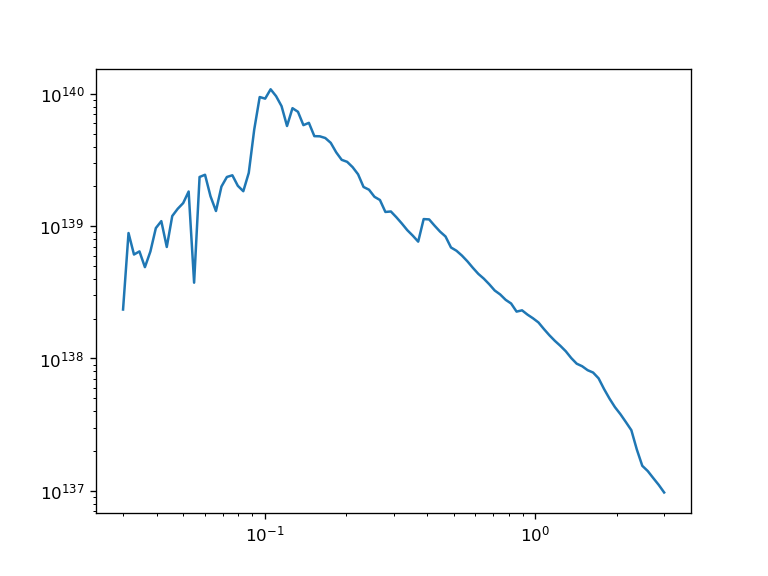

In [11]:
#def exp_sfr_sed(param): #Assumes that the SFR(t) decay exponentially with time
    # param[0]: (log10) peak sfr; param[1]: (log10) burst time
    # param[2]: (log10) e-folding time scale
    #sfr_fn = lambda x: peak_sfr * np.exp( -(t_burst - x)/efolding * (x<t_burst) ) * (x<t_burst)
    
%matplotlib notebook
theory_prediction =  exp_sfr_sed([100,10,10]) # refer to the above comment for the exp_sfr_sed function
#noise = np.random.normal(0, 0.5*theory_prediction)
obs = theory_prediction 
plt.loglog(use_wave/10.**4, obs)

plt.show()

<IPython.core.display.Javascript object>


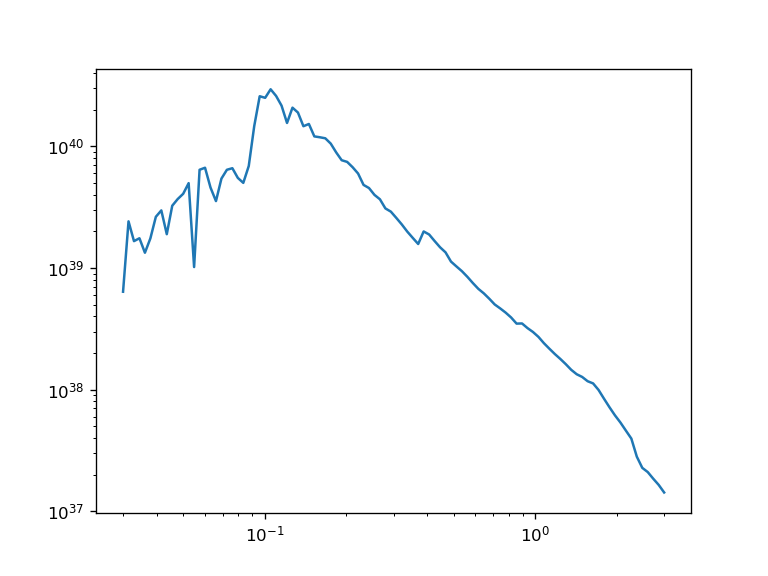

In [34]:
#def non_param_sfr_sed(param): #
    # param[0]: log10 SFR in the first 10 Myr
    # param[1]: log10 SFR in the 10-100 Myr
    # param[2]: log10 SFR in the 100 - 1000 Myr
#     p = np.power(10, param)
#     sfr_fn = lambda t: p[0] * (t<1e7) + p[1] * (t>1e7) * (t<1e8) + p[2] * (t>1e8) * (t<1e9)


##FOR MY OWN TESTING
%matplotlib notebook
#plt.loglog( use_wave, non_param_sfr_sed([1,1.8,0.2]) )
#plt.loglog( use_wave, exp_sfr_sed([1,1.8,0.21
#theory_prediction = non_param_sfr_sed([8,7,6]) #1038
theory_prediction = non_param_sfr_sed([0,0,np.log10(0.1)]) # refer to the above comment for the non_param_sfr_sed function
#noise = np.random.normal(0, 0.5*theory_prediction)
obs = theory_prediction 
plt.loglog(use_wave/10.**4, obs)
plt.show()

In [53]:
np_sim_param = np.random.uniform([-2,-2,0],[2,2,0], size=(500,3))
sim_sed_np_full = np.array([ non_param_sfr_sed( s ) for s in np_sim_param ])
sim_sed_np = np.array([np.mean(sim_sed_np_full[:, -57:-27], axis=1)
                    , np.mean(sim_sed_np_full[:,11:21], axis=1)]).T

In [54]:
np_param_transform = np.power(10, np_sim_param)
np_sfr = lambda t, p: p[0] * (t<=1e7) + p[1] * (t>1e7) * (t<=1e8) + p[2] * (t>1e8) * (t<=1e9)
t_grid = np.power(10, np.linspace(6,9.4,80)) 
sfr_grid = [ np_sfr( t_grid ,p) for p in np_param_transform ]
tot_mass_derived = np.array([get_total_mass(t_grid, s, [1e6, 3e9]) for s in sfr_grid])
tot_mass_derived_10 = np.array([get_total_mass(t_grid, s, [1e6, 1e7]) for s in sfr_grid])
tot_mass_derived_100 = np.array([get_total_mass(t_grid, s, [1e7, 1e8]) for s in sfr_grid])

In [55]:
%matplotlib qt5
plt.scatter( tot_mass_derived_10, np_param_transform[:,0]*1e7, marker='x'
            , s=10
           , c=np.log10(np_param_transform[:,1]/np_param_transform[:,0]) )
plt.xscale('log')
plt.yscale('log')

In [52]:
# sim_param_exp = np.random.multivariate_normal( [1.5, 1.5, 1.5]
#                                               , [[0.3,0,0],[0,0.3,0],[0,0,0.3]], size=500 )
sim_param_exp = np.random.uniform([-2,-2,-1],[3,3,3], size=(500,3))
sim_sed_exp_full = np.array([ exp_sfr_sed( s ) for s in sim_param_exp ])
sim_sed_exp = np.array([np.mean(sim_sed_exp_full[:, -57:-27], axis=1)
                    , np.mean(sim_sed_exp_full[:,11:21], axis=1)]).T

exp_param_transform = np.copy(sim_param_exp)
exp_param_transform[:,1:] += 6
exp_param_transform = np.power(10, exp_param_transform)
exp_sfr = lambda x, p: p[0] * np.exp( -(p[1] - x)/p[2] ) * (x<p[1])
t_grid = np.power(10, np.linspace(6,8,100)) 
sfr_grid = [ exp_sfr( t_grid ,p) for p in exp_param_transform ]
tot_mass_derived_exp = np.array([get_total_mass(t_grid, s, [1e6, 1e9]) for s in sfr_grid])
tot_mass_derived_exp_10 = np.array([get_total_mass(t_grid, s, [1e6, 1e7]) for s in sfr_grid])

<ipython-input-16-da7639411bd1>:22: RuntimeWarning: divide by zero encountered in log10
  param = [np.log10(tot_mass_in_grid), 0, t_mid, 0, 0]
<ipython-input-6-3e592687c710>:40: RuntimeWarning: divide by zero encountered in log10
  , np.log10(sed.get_wavelength()), np.log10(sed_sim))
<ipython-input-52-ca14d3851b94>:11: RuntimeWarning: overflow encountered in exp
  exp_sfr = lambda x, p: p[0] * np.exp( -(p[1] - x)/p[2] ) * (x<p[1])
<ipython-input-52-ca14d3851b94>:11: RuntimeWarning: overflow encountered in multiply
  exp_sfr = lambda x, p: p[0] * np.exp( -(p[1] - x)/p[2] ) * (x<p[1])
<ipython-input-52-ca14d3851b94>:11: RuntimeWarning: invalid value encountered in multiply
  exp_sfr = lambda x, p: p[0] * np.exp( -(p[1] - x)/p[2] ) * (x<p[1])


In [57]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
# ax.scatter( np.log10(sim_sed_exp[:,0]/sim_sed_exp[:,1])
#            , np.log10(sim_sed_exp[:,0]+sim_sed_exp[:,1])
#            , np.log10(tot_mass_derived_exp_10)
#            , s=2, marker=r'x', c='b' )

ax.scatter( np.log10(sim_sed_exp[:,0]/sim_sed_exp[:,1])
           , np.log10(sim_sed_exp[:,0]+sim_sed_exp[:,1])
           , np.log10(tot_mass_derived_exp)
           , s=2, marker=r'x', c='b' )


# ax.scatter( np.log10(sim_sed_np[:,0]/sim_sed_np[:,1])
#            , np.log10(sim_sed_np[:,0] + sim_sed_np[:,1])
# #            , np.log10(tot_mass_derived_10)
#            , np_sim_param[:,0]+7
#            , s=2, marker=r'x', c='g' )

ax.scatter( np.log10(sim_sed_np[:,0]/sim_sed_np[:,1])
           , np.log10(sim_sed_np[:,0] + sim_sed_np[:,1])
#            , np.log10(tot_mass_derived_100 )
           , np_sim_param[:,1]+8
#            , c='y'
           , c=np_sim_param[:,0]-np_sim_param[:,1]
           , s=10, marker=r'^')

# ax.scatter( np.log10(sim_sed_np[:,0]/sim_sed_np[:,1])
#            , np.log10(sim_sed_np[:,0] + sim_sed_np[:,1])
#            , np.log10(tot_mass_derived )
#            , s=10, marker=r'^', c='b' )

# ax.scatter( use_sim_exp_cl[0]
#            , use_sim_exp_cl[1]
# #            , np.log10(use_sim_exp_m10)
#            , scaling_predict
#            , s=10, marker=r'*', c='r' )


# ax.set_xlabel(r"$f_\lambda(\rm{UV})$", fontsize=16)
# ax.set_ylabel(r"$f_\lambda(\rm{IR})$", fontsize=16)
ax.set_xlabel(r"$f_\lambda(\rm{UV})/f_\lambda(\rm{IR})$", fontsize=16)
ax.set_ylabel(r"$f_\lambda(\rm{UV})+f_\lambda(\rm{IR})$", fontsize=16)
# ax.set_zlabel(r"$\rm{SFR}(t)_{\rm{avg}}$", fontsize=16)
ax.set_zlabel(r"$M_{\rm{tot}}$", fontsize=16)
# ax.set_xlim(39, 44)
# ax.set_ylim(35, 41)
ax.set_xlim(1, 4)
ax.set_ylim(36, 44)
ax.set_zlim(6, 11)
# ax.set_zlim(0, 3)
# plt.colorbar()
plt.show()

<ipython-input-57-dee3adcf90a5>:9: RuntimeWarning: invalid value encountered in true_divide
  ax.scatter( np.log10(sim_sed_exp[:,0]/sim_sed_exp[:,1])
<ipython-input-57-dee3adcf90a5>:10: RuntimeWarning: divide by zero encountered in log10
  , np.log10(sim_sed_exp[:,0]+sim_sed_exp[:,1])
<ipython-input-57-dee3adcf90a5>:11: RuntimeWarning: divide by zero encountered in log10
  , np.log10(tot_mass_derived_exp)


In [33]:
np.where( np.log10(sim_sed_exp[:,0]/sim_sed_exp[:,1])>2.5 )

<ipython-input-33-ce1e0e0c7426>:1: RuntimeWarning: invalid value encountered in true_divide
  np.where( np.log10(sim_sed_exp[:,0]/sim_sed_exp[:,1])>2.5 )


(array([  4,  16,  18,  47,  48,  51,  63,  66,  70,  79,  84, 104, 105,
        107, 108, 112, 124, 126, 135, 141, 144, 159, 164, 168, 171, 178,
        188, 189, 197, 200, 208, 227, 228, 249, 251, 253, 264, 277, 281,
        284, 302, 304, 308, 316, 322, 323, 329, 330, 334, 337, 339, 344,
        345, 350, 351, 360, 383, 410, 411, 412, 419, 426, 440, 455, 459,
        464, 470, 488, 490, 492, 494, 496]),)

In [58]:
interest_less = sim_param_exp[ np.where( np.log10(sim_sed_exp[:,0]/sim_sed_exp[:,1])<2.5 ) ]
interest_great = sim_param_exp[ np.where( np.log10(sim_sed_exp[:,0]/sim_sed_exp[:,1])>2.5 ) ]

<ipython-input-58-1caab1f459b9>:1: RuntimeWarning: invalid value encountered in true_divide
  interest_less = sim_param_exp[ np.where( np.log10(sim_sed_exp[:,0]/sim_sed_exp[:,1])<2.5 ) ]
<ipython-input-58-1caab1f459b9>:2: RuntimeWarning: invalid value encountered in true_divide
  interest_great = sim_param_exp[ np.where( np.log10(sim_sed_exp[:,0]/sim_sed_exp[:,1])>2.5 ) ]


In [59]:
%matplotlib qt5
# plt.hist(np.log10(interest[:,1]/interest[:,2]))
plt.hist( interest_great[:,1], alpha=0.3 )
plt.hist( interest_less[:,1], alpha=0.3 )

(array([20., 19., 22., 15., 19., 20., 20., 32., 25., 14.]),
 array([0.86338806, 1.07656341, 1.28973876, 1.50291411, 1.71608945,
        1.9292648 , 2.14244015, 2.3556155 , 2.56879085, 2.7819662 ,
        2.99514155]),
 <BarContainer object of 10 artists>)